In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1, optimization_level_1_df
from qco_spec_table import make_spec_table, show_circuit, qiskit
import seaborn as sns
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer

In [2]:
[ds] = qml.data.load("ketgpt")

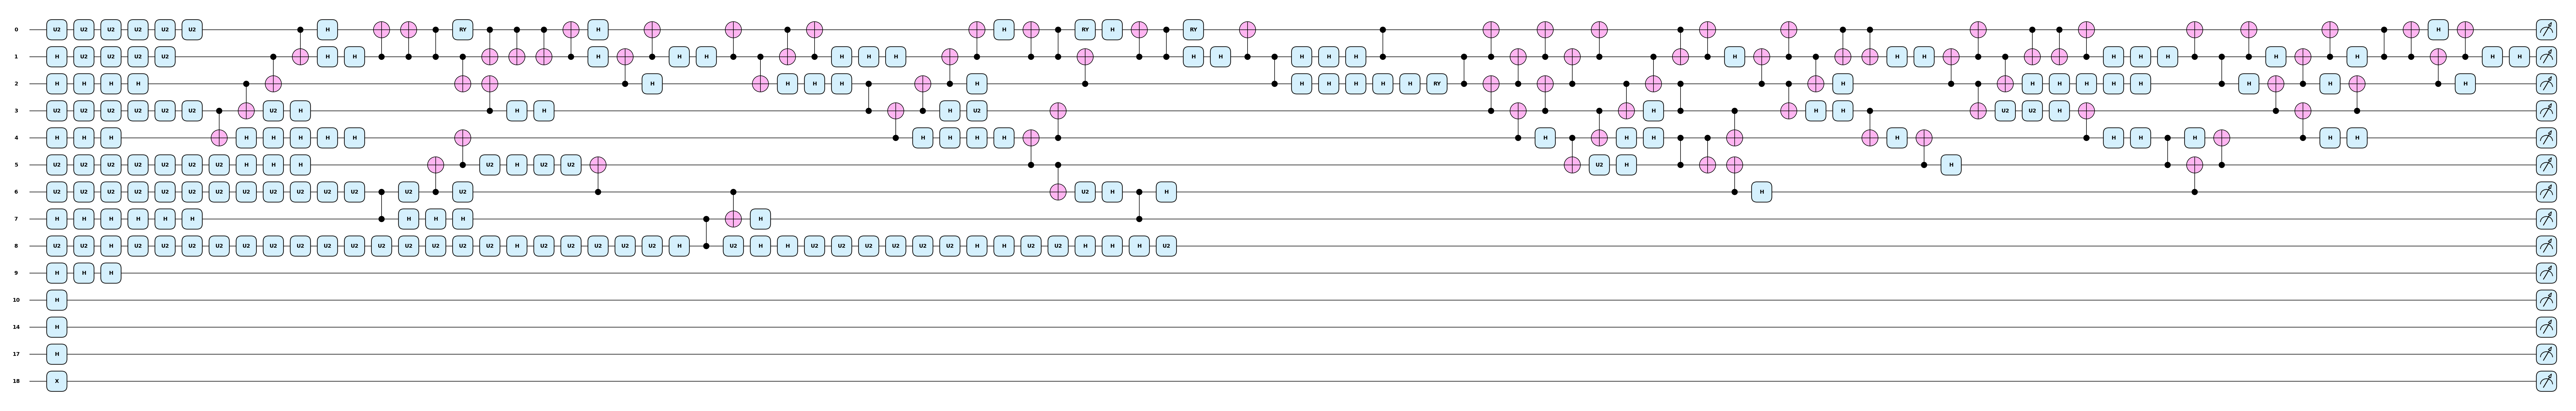

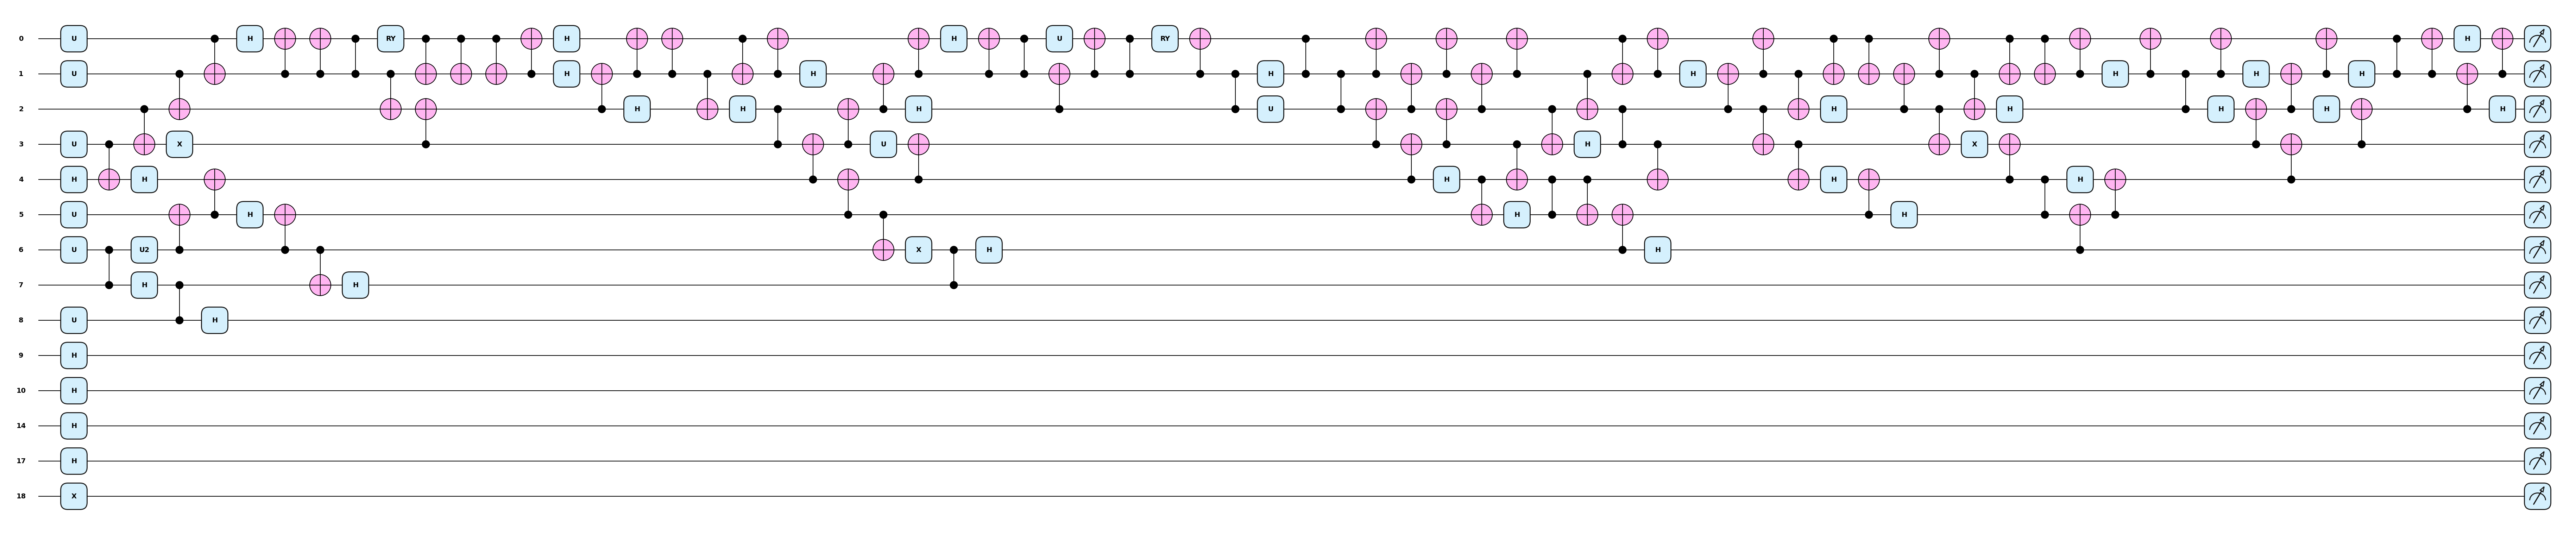

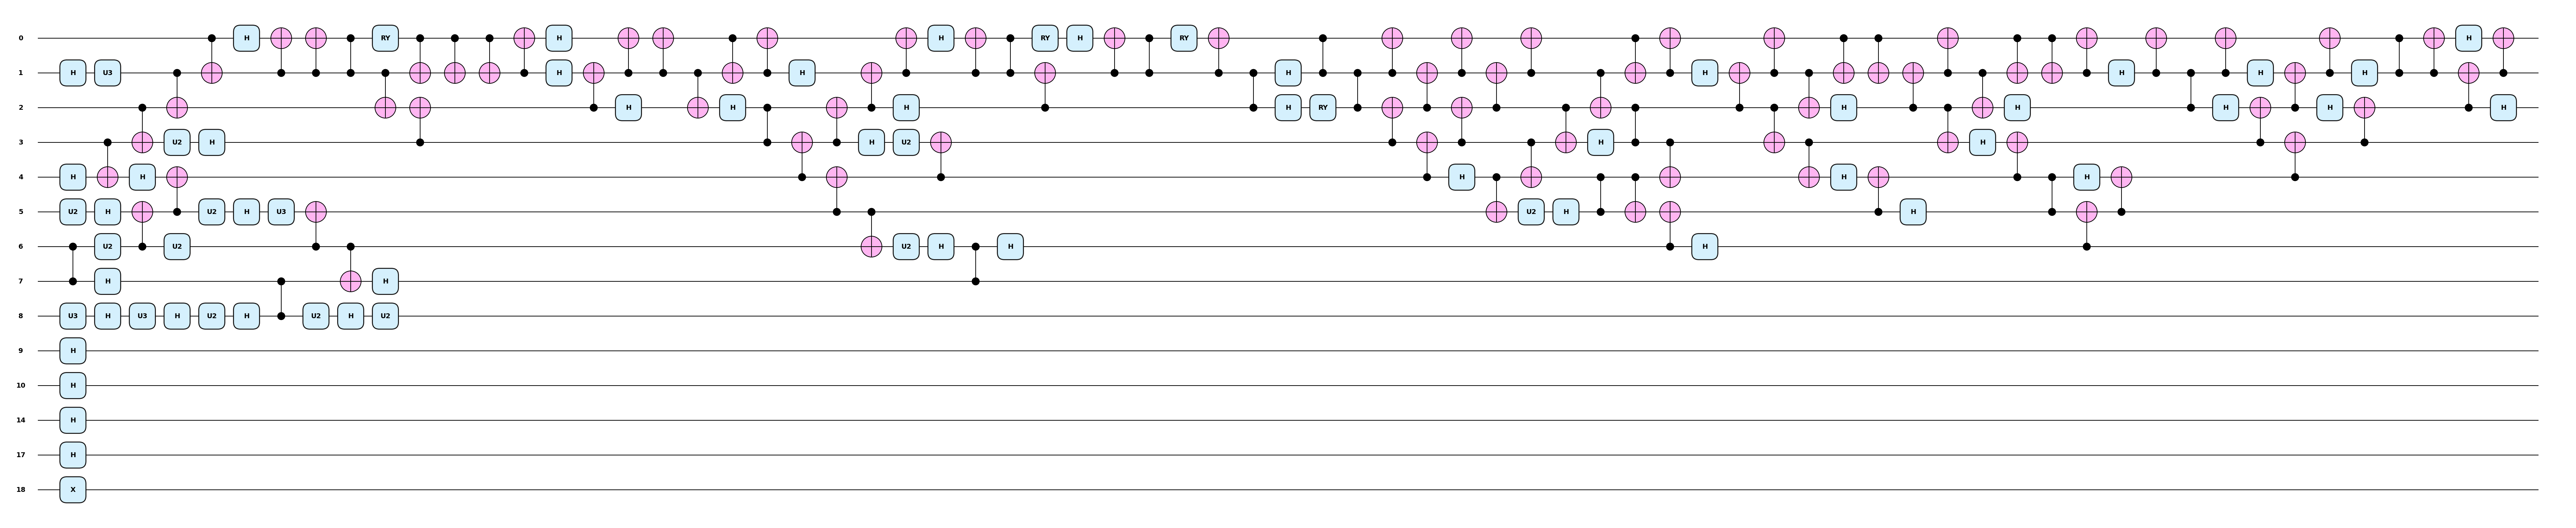

In [3]:
# example
seed = 3
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

show_circuit(circuit)
show_circuit(optimization_level_1(circuit))
# qiskit(circuit).draw('mpl')
show_circuit(qml.from_qiskit(qiskit(circuit)))

In [4]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        qnode_q1, df = optimization_level_1_df(circuit)
        dfs.append(df)
    except:
        pass

In [ ]:
len(dfs)

1000

In [5]:
dfs[0]

,Original,Qiskit,Level 1
gates,141,47,46
1q gates,116,22,21
2q gates,25,25,25
depth,32,24,24
gate types,5,4,3


In [6]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,Level 1
gates,0.333,0.326
1q gates,0.190,0.181
2q gates,1.000,1.000
depth,0.750,0.750
gate types,0.800,0.600


In [7]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

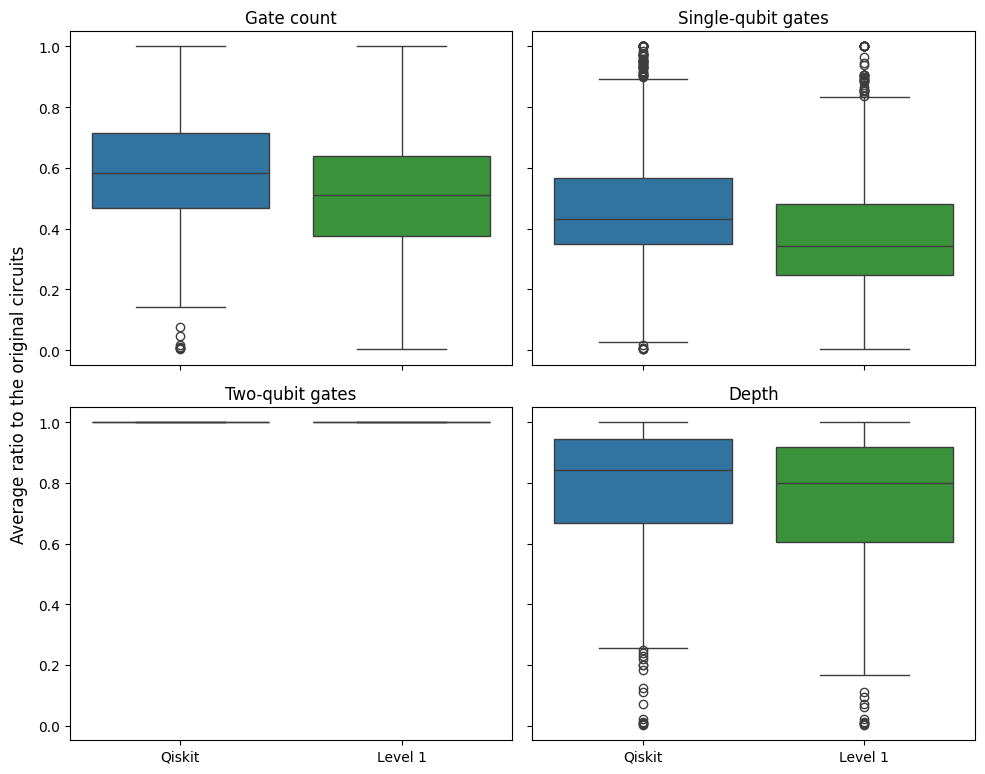

In [8]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)
for i, metric in enumerate(['gates', '1q gates', '2q gates','depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'Level 1': '#2ca02c'}) # 'Qiskit\n(pattern matching)':'#7b1fb4', 'PennyLane': '#ff7f0e'
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    elif i==3:
        ax.set_title('Depth')
    ax.set_xlabel('') 
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [9]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,Level 1,1q gates,0.384570,0.193969,61.5430
1,Level 1,2q gates,1.000000,0.000000,0.0000
2,Level 1,depth,0.746762,0.213753,25.3238
3,Level 1,gate types,0.996437,0.224431,0.3563
4,Level 1,gates,0.515962,0.196409,48.4038
5,Qiskit,1q gates,0.482324,0.206604,51.7676
6,Qiskit,2q gates,1.000000,0.000000,0.0000
7,Qiskit,depth,0.788904,0.198911,21.1096
8,Qiskit,gate types,1.125125,0.151076,-12.5125
9,Qiskit,gates,0.597774,0.192092,40.2226
